In [85]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef
import numpy
from numpyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
import os

In [88]:
#Getting sequences data
dates = ['2022-01-24','2022-01-27','2022-01-31', '2022-02-04','2022-02-08','2022-02-14',
         '2022-02-17','2022-02-18','2022-02-23','2022-02-28','2022-03-03','2022-03-08','2022-03-15'
         ,'2022-03-21','2022-03-25','2022-03-29','2022-03-30','2022-04-07','2022-04-14','2022-04-27'
         ,'2022-05-06','2022-05-13','2022-05-17','2022-05-20','2022-05-26','2022-05-28','2022-06-09'
         ,'2022-06-14','2022-06-22']
        

raw_seq = pd.read_csv(f"data/{dates[5]}/seq-counts_{dates[5]}.tsv", sep="\t")
raw_cases = pd.read_csv(f"data/{dates[5]}/case-counts_{dates[5]}.tsv", sep="\t")

#raw_cases = raw_cases[raw_cases.location == "USA"]
#raw_seq = raw_seq[raw_seq.location == "USA"]
variant_data = ef.CaseFrequencyData(raw_cases=raw_cases, raw_seq=raw_seq)

In [89]:
raw_cases['location'].value_counts()

zeros_location = raw_cases.groupby('location').agg(lambda x: x.eq(0).sum())
print (zeros_location)

# Count number of zeros in all columns of Dataframe
for column_name in raw_cases.columns:
    column = raw_cases[column_name]
    # Get the count of Zeros in column
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

                date  cases
location                   
Australia          0      1
Austria            0      0
Belgium            0     41
Canada             0      0
Denmark            0      2
France             0      1
Germany            0      2
India              0      2
Indonesia          0      1
Israel             0      4
Italy              0      0
Japan              0      0
Netherlands        0      0
New Zealand        0      5
Norway             0      1
Poland             0      0
Singapore          0      3
South Africa       0      3
Sweden             0     56
Switzerland        0     38
USA                0      0
United Kingdom     0      1
Count of zeros in column  date  is :  0
Count of zeros in column  location  is :  0
Count of zeros in column  cases  is :  161


In [43]:
# Defining model
seed_L = 14
forecast_L = 7

# Get delays
v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']

gen = ef.pad_delays(
    [ef.discretise_gamma(mn=4.4, std=1.2), # Delta
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21L
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21K #3.1 std 1.2 
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22A
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22B
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22C
     ef.discretise_gamma(mn=4.4, std=1.2)] # Other
    )

delays = ef.pad_delays([ef.discretise_lognorm(mn=3.1, std=1.0)])
    

    
renewal_model = ef.RenewalModel(gen, delays, seed_L, forecast_L, k=10,
                       RLik = ef.GARW(0.1, 0.1), #Likelihood on effective reproduction number (GARW depend on R and gen time)
                       CLik = ef.ZINegBinomCases(0.05), #Case Likelihood
                       SLik = ef.DirMultinomialSeq(100), #Sequence Likelihood
                       v_names = v_names)

In [82]:
# Fitting MAP model getting point
svi_MAP = ef.InferMAP(iters=20_000, lr=0.01)

posterior = svi_MAP.fit(renewal_model, variant_data)

In [ ]:
#Fitting full_rank svi model to get all distrubtions
svi_fullrank = ef.InferFullRank(iters = 20_000, lr = 0.01, num_samples=1000)

posterior = svi_fullrank.fit(renewal_model, variant_data)
plt.plot(posterior.samples['losses'])
plt.yscale('log')

In [ ]:
#Fitting mcmc models 
mcmc = ef.InferNUTS(num_warmup= 800, num_samples= 200)
posterior = mcmc.fit(renewal_model, variant_data)
mcmc.handler.mcmc.print_summary()

In [83]:
#Exporting forecast data
from pathlib import Path
filepath = Path('/Users/eslamabousamra/rt_frq_dyn_datasets/ncov-forecasting-fit/cast_estimates')  
filepath.parent.mkdir(parents=True, exist_ok=True)

#export posterior frequencies with no forecast
def save_forecast_freq(samples, variant_data, ps, forecast_date):
    #only need last 14 days
    freq_now = pd.DataFrame(ef.get_freq(samples, variant_data, ps, name=forecast_date, forecast = False))
    #Get the freq dates nowcast period
    nowcast_dates = variant_data.dates[-14:]
    freq_now = freq_now[freq_now['date'].isin(nowcast_dates)]
    freq_fr = pd.DataFrame(ef.get_freq(samples, variant_data, ps, name=forecast_date, forecast = True))
    freq_now.to_csv(f'{filepath}/freq_nowcast_{forecast_date}.csv', index = False)
    freq_fr.to_csv(f'{filepath}/freq_forecast_{forecast_date}.csv', index = False)


In [84]:
save_forecast_freq(posterior.samples, variant_data, ps, dates[3])

In [ ]:
for each in forecast_date:
    save_forecast_freq(posterior.samples, variant_data, ps, forecast_date)

In [47]:
from evofr.plotting import *

In [46]:
#Plotting

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 26}

matplotlib.rc('font', **font)
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

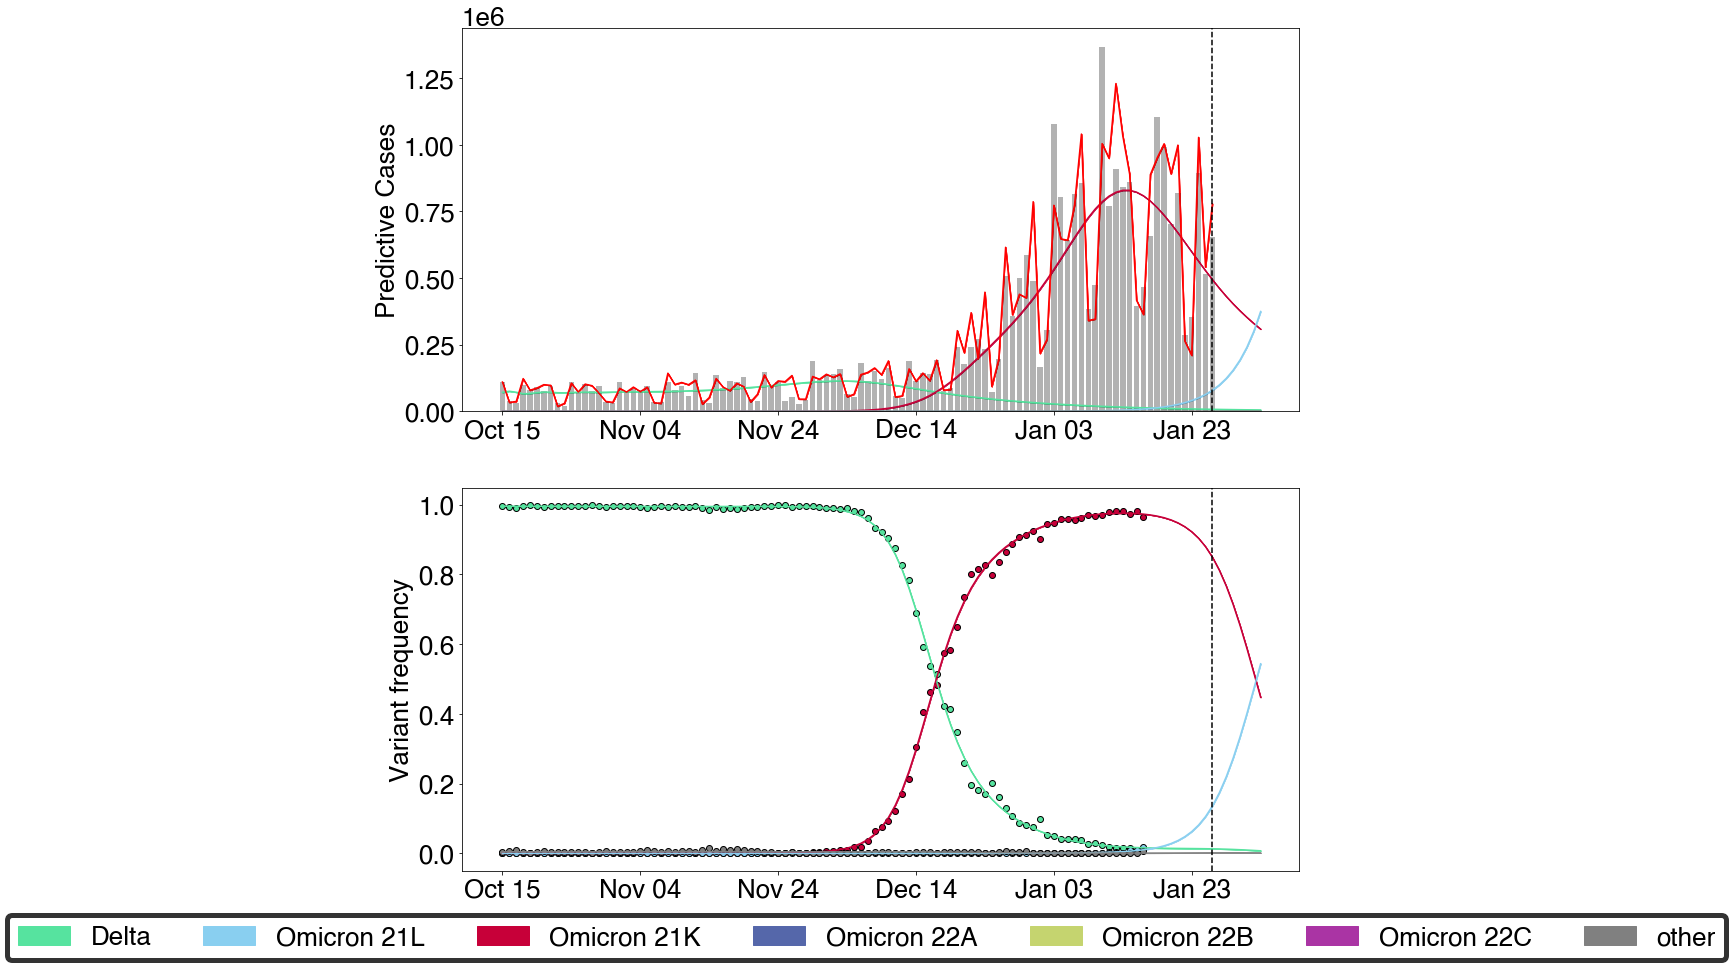

In [62]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(nrows=2, ncols=1)

colors = [color_map[v] for v in variant_data.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[0,0])
plot_posterior_I(ax, posterior.samples, ps, alphas, colors, forecast=True)
plot_ppc_cases(ax, posterior.samples, ps, alphas, 'red')
plot_cases(ax, variant_data)
ax.axvline(x=len(variant_data.dates)-1, color='k', linestyle='--') # Adding forecast cut off
ax.set_ylabel("Predictive Cases") # Making ylabel

# Plot predicted frequencies
ax = fig.add_subplot(gs[1,0], sharex=ax)
post_freq = plot_posterior_frequency(ax, posterior.samples, ps, alphas, colors, forecast=True)
plot_observed_frequency(ax, variant_data, colors) # Plot observed frequencies
#plot_ppc_frequency(ax, posterior.samples, variant_data,  ps, alphas, colors)
ax.axvline(x=len(variant_data.dates)-1, color='k', linestyle='--') # Adding forecast cut off
add_dates_sep(ax, ef.data.expand_dates(variant_data.dates, forecast_L), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel



# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(5.)
legend.get_frame().set_edgecolor("k")
#fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)

In [ ]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(nrows=2, ncols=1)

colors = [color_map[v] for v in variant_data.var_names] # Mapping colors to observed variants

# Plot Reff
ax = fig.add_subplot(gs[0,0])
plot_R_censored(ax, posterior.samples, ps, alphas, colors)
ax.set_ylabel("Effective Reproduction number") # Making ylabel

# Plot little R
ax = fig.add_subplot(gs[1,0])
plot_little_r_censored(ax, posterior.samples, ps, alphas, colors)
add_dates_sep(ax, variant_data.dates, sep=20) # Adding dates
ax.set_ylabel("Epidemic growth rate (per day)") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)